In [1]:
print(__doc__)

# Code source adapted from: Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
import pandas as pd
import os
import csv
import pprint

pp = pprint.PrettyPrinter(indent=4)

Automatically created module for IPython interactive environment


In [2]:
def treat_dataset(dataset):
    vcut = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
    vcolor = {'D': 6, 'E': 5, 'F': 4, 'G': 3, 'H': 2, 'I': 1, 'J': 0}
    vclarity = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
    
    target = []
    for row in dataset:
        # Modify string to number values
        row["cut"] = vcut[row["cut"]]
        row["color"] = vcolor[row["color"]]
        row["clarity"] = vclarity[row["clarity"]]
        
        # Normalize values
        row["carat"] = (float(row["carat"]) - (0.2+5.01)/2)/(0.2+5.01)
        row["cut"] = (float(row["cut"]) - (4/2))/4
        row["color"] = (float(row["color"]) - (6/2))/6
        row["clarity"] = (float(row["clarity"]) - (7/2))/7
        row["x"] = (float(row["x"]) - (10.74/2))/10.74
        row["y"] = (float(row["y"]) - (58.9/2))/58.9
        row["z"] = (float(row["z"]) - (31.8/2))/31.8
        row["depth"] = (float(row["depth"]) - (43+79)/2)/(43+79)
        row["table"] = (float(row["table"]) - (43+95)/2)/(43+95)
        
        # Add X0 for ease of use
        row["x0"] = 1
        
        # Remove target element and insert into it's own list
        target.append(float(row["price"]))
        del row["price"]
    return target

In [3]:
# Read and treat training dataset
dataset_train = []
reader = csv.DictReader(open('diamonds-train.csv', 'r'))
for line in reader:
     dataset_train.append(line)

target_train = treat_dataset(dataset_train)

# Read and treat test dataset
dataset_test = []
reader = csv.DictReader(open('diamonds-test.csv', 'r'))
for line in reader:
     dataset_test.append(line)

target_test = treat_dataset(dataset_test)

# Auxilary vector for name to number mapping
ds_index = ["x0", "carat", "clarity", "color", "cut", "depth", "table", "x", "y", "z", "price"]

In [4]:
def calculate_cost_function(thetas, data, target):
    m = len(data)
    s = 0
    for index in range(len(data)):
        h = 0
        for k,v in data[index].items():
            h += thetas[k] * data[index][k]
        s += (h - float(target[index]))*(h - float(target[index]))
    return (1/(2*m)) * s

def init_thetas(data):
    if len(data) == 0:
        return {}
    thetas = {}
    for k,v in data[0].items():
        thetas[k] = 0
    return thetas

def plot(x, y, c='black'):
    plt.scatter(x, y, color= c)

    plt.xticks()
    plt.yticks()

    plt.show()

In [9]:
#####################################
#                                   #
#       STOCHASTIC ALGORITHM        #
#                                   #
#####################################

# Parameters:

learningRate    = 1e-03
max_iterations  = 1000000
batch_size      = 10
stopCondition   = 1e-03


thetas     = init_thetas(dataset_train)
done       = False
m          = len(dataset_train)
iterations = 0

# After j_step iterations, compute cost function
j_step      = 10
costs       = []
itr_numbers = []

# print(calculate_cost_function(thetas, train_df, target_train_df))

# In the Stochastic mode, the error is calculated using only one row of the data set
# We'll use them one by one 
row = 0
while(iterations < max_iterations and not done):
    
    new_thetas = thetas.copy() 
        
    # For each theta we do the following
    for k1,v1 in thetas.items():
        h = 0
        
        for k2,v2 in thetas.items():
            h += v2 * dataset_train[row][k2]

        # Updating the new thetas vector values
        new_thetas[k1] = v1 - (learningRate * (h - float(target_train[row])) * dataset_train[row][k1])
        
    # Updating row that will be used to calculate the error
    row = (row + 1) % m
    
    if iterations % j_step == 0:
        costs.append(calculate_cost_function(thetas, dataset_train, target_train))
        itr_numbers.append(iterations)
        
    # If the change in value for new thetas is too small, we can stop iterating
    done = True
    for k,v in thetas.items():
        done = abs(thetas[k] - new_thetas[k]) < stopCondition and done    
        
     # Atualization of the values of the thetas
    thetas = new_thetas.copy()
    iterations = iterations + 1
    
if iterations >= max_iterations:
    print("Stopped by number of iterations\n")
if done:
    print("Stopped by convergence\n")

Stopped by number of iterations



In [ ]:
print("Coefficients: \n")
pp.pprint(thetas)

plot(itr_numbers, costs)

In [7]:
#####################################
#                                   #
#     BATCH GRADIENT ALGORITHM      #
#                                   #
#####################################

# Parameters:

learningRate    = 1e-03
max_iterations  = 100
batch_size      = 10
stopCondition   = 1e-03


thetas     = init_thetas(dataset_train)
done       = False
m          = len(dataset_train)
iterations = 0

# After j_step iterations, compute cost function
j_step      = 10
costs       = []
itr_numbers = []


while(iterations < max_iterations and not done):
    
    new_thetas = thetas.copy()
    
    # For each theta we do the following
    for key,item in thetas.items():
        
        s = 0
        # We add every row of the dataset to the error calculation (Batch)
        for i in range(len(dataset_train)):
            
            h = 0
            # Calculating the value for theta
            for kt,it in thetas.items():
                h += thetas[kt] * dataset_train[i][kt]
                
            s += (h - float(target_train[i])) * dataset_train[i][key]
        
        # Updating the new thetas vector values
        new_thetas[key] = thetas[key] - ((learningRate / m) * s)
    
    if iterations % j_step == 0:
        costs.append(calculate_cost_function(thetas, dataset_train, target_train))
        itr_numbers.append(iterations)
    
    # If the change in value for new thetas is too small, we can stop iterating
    done = True
    for k,v in thetas.items():
        done = abs(thetas[k] - new_thetas[k]) < stopCondition and done

    # Atualization of the values of the thetas
    thetas = new_thetas.copy()
    iterations = iterations + 1
    
if iterations >= max_iterations:
    print("Stopped by number of iterations\n")
if done:
    print("Stopped by convergence\n")

Stopped by number of iterations



Coefficients: 

{   'carat': -1.029701330902258,
    'clarity': -0.38942557089576785,
    'color': 0.07596207114659047,
    'cut': 0.8308993107810421,
    'depth': 0.023345018751861596,
    'table': -0.32077821146352653,
    'x': 0.5010457284829412,
    'x0': 3.9325155619533687,
    'y': -1.5163804125456388,
    'z': -1.4525187379860882}


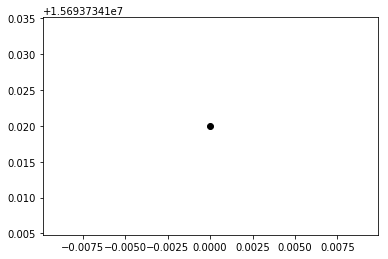

In [8]:
print("Coefficients: \n")
pp.pprint(thetas)

plot(itr_numbers, costs)

In [6]:
#####################################
#                                   #
#   MINI BATCH GRADIENT ALGORITHM   #
#                                   #
#####################################

# Parameters:

learningRate    = 1e-03
max_iterations  = 100000
batch_size      = 10
stopCondition   = 1e-03


thetas     = init_thetas(dataset_train)
done       = False
m          = len(dataset_train)
iterations = 0

# After j_step iterations, compute cost function
j_step      = 1000
costs       = []
itr_numbers = []


while(iterations < max_iterations and not done):
    
    # Step through the dataset in chuncks
    for row in range(0, len(dataset_train), batch_size):
        new_thetas = thetas.copy()
        
        # For each theta we do the following
        for k,val in thetas.items():

            s = 0
            # We add every row of the dataset to the error calculation (Batch)
            for offset in range(batch_size):
                if row + offset >= m:
                    break
                
                h = 0
                # Calculating the value for theta
                for i,v in thetas.items():
                    h += thetas[i] * dataset_train[row+offset][i]

                s += (h - float(target_train[row+offset])) * dataset_train[row+offset][k]

            # Updating the new thetas vector values
            new_thetas[k] = thetas[k] - ((learningRate / batch_size) * s)
        
        if iterations % j_step == 0:
            costs.append(calculate_cost_function(thetas, dataset_train, target_train))
            itr_numbers.append(iterations)
        
        iterations = iterations + 1
        if iterations >= max_iterations:
            break
            
        # If the change in value for new thetas is too small, we can stop iterating
        done = True
        for k,v in thetas.items():
            done = abs(thetas[k] - new_thetas[k]) < stopCondition and done
        if done:
            break

        # Atualization of the values of the thetas
        thetas = new_thetas.copy()
    
if iterations >= max_iterations:
    print("Stopped by number of iterations\n")
if done:
    print("Stopped by convergence\n")

Stopped by number of iterations



In [ ]:
print("Coefficients: \n")
pp.pprint(thetas)

plot(itr_numbers, costs)

In [11]:
#####################################
#                                   #
#          NORMAL EQUATION          #
#                                   #
#####################################

mat_train = []
mat_target = []
for row in range(len(dataset_train)):
    mat_train.append([])
    mat_target.append([target_train[row]])
    for col in dataset_train[row]:
        mat_train[row].append(dataset_train[row][col])

mat_train = np.matrix(mat_train)
mat_train_T = mat_train.transpose()
mat_target = np.matrix(mat_target)

thetas = np.matmul(np.matmul(inv(np.matmul(mat_train_T, mat_train)), mat_train_T), mat_target)

print(thetas)

[[   454.66548112]
 [  2786.81982383]
 [-10003.47913586]
 [ 24592.08801244]
 [  -127.34095635]
 [-10349.14729871]
 [ 56396.15665186]
 [  1940.31623813]
 [ -4392.06386144]
 [  3515.0095121 ]]


In [12]:
mat_test = []
for row in range(len(dataset_test)):
    mat_test.append([])
    for col in dataset_test[row]:
        mat_test[row].append(dataset_test[row][col])

res = []
for rows in mat_test:
    res.append(np.matmul(rows,thetas)[0,0])

for i in range(len(res)):
    print(target_test[i], res[i], target_test[i] - res[i])

2220.0 2854.0822561873706 -634.0822561873706
5041.0 6536.149451722529 -1495.1494517225292
6145.0 7096.398827800365 -951.3988278003653
4637.0 6364.893013302509 -1727.8930133025087
2326.0 1738.035107836766 587.964892163234
1662.0 1571.0153319712954 90.98466802870462
8608.0 7956.096909779014 651.9030902209861
827.0 521.6167113261647 305.3832886738353
14338.0 10641.247008070219 3696.7529919297813
766.0 1692.3104962372392 -926.3104962372392
9262.0 8535.050457913887 726.9495420861131
1800.0 1896.260754139405 -96.26075413940498
1072.0 583.5306127970877 488.46938720291234
5649.0 7102.0156366425845 -1453.0156366425845
5898.0 6926.481236040814 -1028.481236040814
14125.0 13261.1392763767 863.8607236233001
6504.0 5587.510299826738 916.4897001732616
873.0 1082.1020342861734 -209.10203428617342
1874.0 1278.9790173189797 595.0209826810203
567.0 508.22966737271366 58.770332627286336
3461.0 5045.249018331697 -1584.2490183316968
1088.0 1537.655676217396 -449.6556762173959
5201.0 5418.740593931849 -217.7

2069.0 2210.4037897969483 -141.40378979694833
4969.0 5790.994010847437 -821.9940108474366
1227.0 817.284491406682 409.71550859331796
4915.0 6025.699028736865 -1110.6990287368653
429.0 -538.1997805465729 967.1997805465729
5645.0 6692.999941042155 -1047.9999410421551
1171.0 2696.1856256202022 -1525.1856256202022
2307.0 2598.789677721884 -291.7896777218839
394.0 -861.0401036514351 1255.040103651435
743.0 297.1499840996557 445.8500159003443
1851.0 1730.9164840053697 120.08351599463026
1574.0 1840.7939658888674 -266.79396588886743
936.0 906.3217108548954 29.6782891451046
5480.0 5452.8646598703235 27.13534012967648
7260.0 7251.294384129633 8.705615870367183
16148.0 13830.428496333983 2317.5715036660167
1425.0 1598.8877794680127 -173.8877794680127
4566.0 5389.2728663115995 -823.2728663115995
625.0 4.5854703138761295 620.4145296861238
3773.0 3709.7550829129614 63.24491708703863
1094.0 -122.8372591836378 1216.8372591836378
5061.0 5208.781715248195 -147.7817152481948
4746.0 4831.639625378655 -85

1786.0 1992.2627148899442 -206.26271488994416
13879.0 13927.416882247033 -48.416882247032845
7661.0 7110.597503809914 550.4024961900859
1580.0 1897.4431040446027 -317.4431040446027
6097.0 5696.523124610125 400.4768753898752
743.0 -66.88411589109634 809.8841158910964
7105.0 7532.485801440247 -427.4858014402471
5699.0 6547.26498071456 -848.2649807145599
7334.0 6412.766209947394 921.2337900526063
1689.0 2143.192480962737 -454.19248096273714
5518.0 7292.297819312815 -1774.2978193128147
3894.0 6087.7674559775805 -2193.7674559775805
2257.0 2524.448680171312 -267.44868017131193
455.0 -707.5362845307218 1162.5362845307218
15968.0 10823.50190801201 5144.498091987991
907.0 1017.068436987932 -110.06843698793205
1087.0 615.6121504502596 471.3878495497404
1778.0 2285.0907291666194 -507.09072916661944
6557.0 8093.438190066836 -1536.438190066836
725.0 1704.2050724764078 -979.2050724764078
957.0 253.6774379931338 703.3225620068662
4476.0 4469.710681157724 6.289318842275861
2807.0 3558.840555092554 -75

16611.0 14062.688059863922 2548.311940136078
827.0 1042.573100332916 -215.57310033291606
6542.0 6742.605386874475 -200.6053868744748
647.0 1198.0324900322564 -551.0324900322564
3273.0 3744.0852596548725 -471.0852596548725
1193.0 892.256535556505 300.743464443495
1103.0 1707.4987620883262 -604.4987620883262
3624.0 4153.4316647851565 -529.4316647851565
3632.0 4639.96380144237 -1007.9638014423699
5813.0 5774.541795697045 38.45820430295498
3634.0 4976.053366108079 -1342.053366108079
4688.0 4501.42813584415 186.57186415584965
743.0 318.302381933181 424.697618066819
8227.0 10943.690700500998 -2716.690700500998
759.0 1443.0671635004132 -684.0671635004132
5197.0 5249.7989895043165 -52.79898950431652
655.0 1361.7183152313046 -706.7183152313046
695.0 1522.7395927582802 -827.7395927582802
5292.0 5127.460469000742 164.5395309992582
1195.0 2266.689033104439 -1071.6890331044392
666.0 350.4194576935754 315.5805423064246
886.0 2127.0345097974623 -1241.0345097974623
5047.0 4532.928768952936 514.0712310

13825.0 14068.722549391523 -243.722549391523
3660.0 4220.16220415035 -560.1622041503497
5308.0 6181.275035353962 -873.2750353539623
6176.0 5846.070223700222 329.9297762997776
5889.0 6261.823297470281 -372.82329747028143
5801.0 6221.544359630645 -420.544359630645
1127.0 2124.251719801489 -997.2517198014889
761.0 1095.1241810667882 -334.1241810667882
778.0 777.2305878184823 0.7694121815177368
14616.0 10677.766584233756 3938.2334157662444
1163.0 1791.336366346793 -628.336366346793
4623.0 4929.23502889249 -306.23502889248994
2333.0 2634.2259905776145 -301.22599057761454
1608.0 2563.6750600511587 -955.6750600511587
732.0 333.8622814070252 398.1377185929748
2942.0 3249.8182857559837 -307.81828575598365
3878.0 3967.487695414844 -89.48769541484398
11703.0 10268.899797527381 1434.1002024726185
5433.0 5471.394170021506 -38.3941700215064
5504.0 5481.408421034495 22.591578965504596
1622.0 1859.727163558633 -237.72716355863304
3819.0 4636.8765568711215 -817.8765568711215
798.0 -194.7920261027848 99

3461.0 4070.7219298567225 -609.7219298567225
1989.0 2561.160577810039 -572.1605778100388
5499.0 5383.586685439455 115.41331456054468
631.0 -732.2533909028339 1363.2533909028339
4549.0 5144.150710251613 -595.1507102516134
776.0 -109.152527965291 885.152527965291
1580.0 2630.537840431565 -1050.5378404315652
4278.0 7202.567283839826 -2924.567283839826
4278.0 7202.567283839826 -2924.567283839826
3360.0 4038.448490454638 -678.448490454638
3332.0 4467.828159493482 -1135.8281594934824
901.0 1045.8144206444883 -144.81442064448834
4181.0 4379.795890905513 -198.79589090551326
1228.0 1519.168648242191 -291.168648242191
3234.0 3945.3127712906235 -711.3127712906235
1712.0 1915.0390985544127 -203.0390985544127
4121.0 4775.732576204405 -654.7325762044047
526.0 913.535386607007 -387.535386607007
394.0 -1015.0206411841831 1409.0206411841832
4821.0 5110.579638401321 -289.57963840132106
8437.0 6987.552323777772 1449.4476762222284
1719.0 1544.1284880695587 174.87151193044133
847.0 747.0935801297837 99.906

1281.0 819.8975953346715 461.10240466532855
1053.0 1681.8915848826691 -628.8915848826691
4788.0 4498.374865225856 289.6251347741436
1013.0 1287.6752594248385 -274.6752594248385
9033.0 9750.289831634189 -717.2898316341889
669.0 -479.8834612417899 1148.88346124179
6745.0 6237.256596144544 507.74340385545565
692.0 863.4666890014745 -171.4666890014745
586.0 1632.8081416569892 -1046.8081416569892
3569.0 3656.7150652796017 -87.71506527960173
4131.0 4210.567638474936 -79.56763847493585
942.0 912.1546688422233 29.84533115777674
8778.0 7519.42580385172 1258.57419614828
4741.0 4765.459157576589 -24.45915757658895
1073.0 269.6036815030036 803.3963184969964
1018.0 2585.909093713555 -1567.9090937135552
686.0 193.8034421397911 492.19655786020894
1621.0 3153.3660414105416 -1532.3660414105416
694.0 1139.1105138589685 -445.1105138589685
1733.0 1912.0105210287757 -179.01052102877566
5655.0 6051.570836643999 -396.5708366439994
741.0 1256.0000649658646 -515.0000649658646
2213.0 2037.068041398997 175.93195

5423.0 5795.038262356112 -372.0382623561118
863.0 1836.965397456823 -973.965397456823
694.0 1400.1993742274672 -706.1993742274672
1838.0 1906.8586124323313 -68.85861243233126
1665.0 2329.4257168365853 -664.4257168365853
778.0 1247.372636020341 -469.3726360203409
526.0 -511.75613813967334 1037.7561381396733
14383.0 14859.99014076664 -476.99014076664025
15745.0 13857.607607627415 1887.3923923725852
3104.0 3355.7981135249374 -251.79811352493743
2519.0 2990.2114769767722 -471.21147697677225
4560.0 4438.026396288744 121.97360371125615
3457.0 3881.3914627431423 -424.39146274314226
10602.0 8286.454103056836 2315.545896943164
405.0 -1853.9226275161898 2258.92262751619
4851.0 5352.775848164336 -501.7758481643359
4497.0 4339.127949327179 157.8720506728214
1080.0 1517.8793546151599 -437.87935461515985
625.0 256.22219473477764 368.77780526522236
1914.0 2636.524592950511 -722.5245929505109
2980.0 4376.175046764192 -1396.1750467641923
1709.0 2044.5582620951386 -335.5582620951386
603.0 564.2055986154

706.0 310.1702355581151 395.8297644418849
2307.0 2463.105647446613 -156.10564744661315
671.0 263.8469375911609 407.1530624088391
4916.0 4767.883527647399 148.1164723526008
422.0 -1173.1921973110393 1595.1921973110393
752.0 1276.317197677808 -524.317197677808
6912.0 6290.1710489500565 621.8289510499435
6182.0 7526.708396314604 -1344.7083963146042
8778.0 7868.2903831274725 909.7096168725275
648.0 187.47606710740754 460.5239328925925
3879.0 3864.2042031554583 14.795796844541655
11220.0 9494.98506747822 1725.0149325217808
878.0 966.539912429525 -88.53991242952497
10954.0 7762.858650338757 3191.141349661243
612.0 -355.7892775668887 967.7892775668887
716.0 133.90045422997778 582.0995457700222
891.0 -24.918202302331338 915.9182023023313
12654.0 13397.50505407208 -743.5050540720804
821.0 1401.8353333937896 -580.8353333937896
4608.0 4660.90635065279 -52.906350652790024
5098.0 6162.204746990431 -1064.204746990431
14915.0 10553.66595145255 4361.334048547449
4440.0 5039.594123324627 -599.594123324

In [ ]:
#####################################
#                                   #
#     SKLEARN LINEAR REGRESSION     #
#                                   #
#####################################


dt = []
for row in range(len(dataset_train)):
    dt.append([])
    for col in dataset_train[row]:
        dt[row].append(dataset_train[row][col])
dtest = []
for row in range(len(dataset_test)):
    dtest.append([])
    for col in dataset_test[row]:
        dtest[row].append(dataset_test[row][col])
# Create linear regression object
regr = linear_model.SGDRegressor(max_iter=100000, eta0=0.0001)

# Train the model using the training sets
regr.fit(dt, target_train)

# Make predictions using the validation set
diabetes_y_pred = regr.predict(dtest)

# Print predictions 
print(diabetes_y_pred)
print(target_test)